### 데이터 불러오기

In [198]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
#from sklearn.impute import SimpleImpute
import statsmodels.api as sm
import matplotlib.pyplot as plt

## 01. 기본전처리

In [199]:
heat = pd.read_csv("C:/Users/USER/OneDrive/바탕 화면/내 자료/4-1준비/체크난방/train_heat.csv", index_col=0)
heat.head()

# 컬럼명에서 train_heat. 제거
heat.columns = heat.columns.str.replace("train_heat.", "", regex=False)
heat.head(2)

# 날짜 데이터를 데이트타임으로 변경
heat['tm'] = pd.to_datetime(heat['tm'].astype(str), format="%Y%m%d%H")

# 263069개의 결측치 -> na로 대체
heat = heat.replace(-99, np.nan)

# 풍향 -9.9 값을 NaN으로 변경
heat['wd'] = heat['wd'].replace(-9.9, np.nan)

#타겟칼럼이 null이면 삭제
heat = heat.dropna(subset=['heat_demand'])
heat


,tm,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,heat_demand
1,2021-01-01 01:00:00,A,-10.1,78.3,0.5,0.0,0.0,68.2,NaN,-8.2,281.0
2,2021-01-01 02:00:00,A,-10.2,71.9,0.6,0.0,0.0,69.9,NaN,-8.6,262.0
3,2021-01-01 03:00:00,A,-10.0,360.0,0.0,0.0,0.0,69.2,NaN,-8.8,266.0
4,2021-01-01 04:00:00,A,-9.3,155.9,0.5,0.0,0.0,65.0,NaN,-8.9,285.0
5,2021-01-01 05:00:00,A,-9.0,74.3,1.9,0.0,0.0,63.5,NaN,-9.2,283.0
...,...,...,...,...,...,...,...,...,...,...,...
499297,2023-12-31 19:00:00,S,3.2,233.5,0.4,2.5,0.0,91.5,NaN,2.8,34.0
499298,2023-12-31 20:00:00,S,2.9,227.4,0.1,2.5,0.0,92.1,NaN,2.7,35.0
499299,2023-12-31 21:00:00,S,2.1,360.0,0.0,2.5,0.0,93.3,NaN,1.4,35.0
499300,2023-12-31 22:00:00,S,2.2,30.0,1.4,2.5,0.0,95.5,NaN,1.3,40.0


## 02. branch_id(지사)별로 새로운 데이터셋 생성

In [200]:
#클러스터링 이후 변경
high_df = heat[heat['branch_id'].isin(['A', 'K', 'R', 'Q', 'P', 'O'])]
mid_df = heat[heat['branch_id'].isin(['N', 'M', 'L', 'J', 'B', 'I'])]
low_df = heat[heat['branch_id'].isin(['H', 'G', 'F', 'E', 'D', 'C', 'S'])]

## 03. 결측치 처리

#### 1. ‘강수량만’ 결측인 경우가 딱, 비가 많이 오는 시기라서 어떻게 처리할지 고민

밑의 방법 중에 골라서 코드 수정해야함. 일단 장기/단기 예측에 동일하게 넣어져있는 상태임. 

방법1) 같은 클러스터 내에서 동일시간대 평균 내서 대체한다. (모두가 NULL값인 날이 없다는 것을 가정)
-> 이거면 코드 수정 안 해도됨

방법2) 다른 COL을 이용하여 유추한다.. 외부 자료 이용하기

방법3) 풍향 혹은 온도가 비슷한 다른 branch의 값을 이용해서 넣어주기.. (우리가 클러스터 하는게 사실 거리기반이 아니니까 같은 클러스터 내에서 온도가 비슷하다고 특정지을 수 없을 것 같음 .그래서 cluster나눠주기 전에 강수량만 결측치 따로 처리??)

In [175]:
# 공통 변수 목록
vars_to_check = ['ta', 'wd', 'ws', 'si', 'ta_chi', 'hm', 'heat_demand']

# high cluster
high_filtered = high_df[
    high_df['rn_day'].isna() &
    high_df['rn_hr1'].isna() &
    high_df[vars_to_check].notna().all(axis=1)
]

# mid cluster
mid_filtered = mid_df[
    mid_df['rn_day'].isna() &
    mid_df['rn_hr1'].isna() &
    mid_df[vars_to_check].notna().all(axis=1)
]

# low cluster
low_filtered = low_df[
    low_df['rn_day'].isna() &
    low_df['rn_hr1'].isna() &
    low_df[vars_to_check].notna().all(axis=1)
]

# 결과 개수 출력
print(f"High cluster: {len(high_filtered):,} rows")
print(f"Mid cluster: {len(mid_filtered):,} rows")
print(f"Low cluster: {len(low_filtered):,} rows")

High cluster: 976 rows
Mid cluster: 529 rows
Low cluster: 1,042 rows


### 2. 'ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm' 변수

1)장시간 결측

In [201]:
# 장시간결측 (5시간 이상)

def compute_null_streaks(df, column_name):
    """
    특정 column에 대해 branch별 연속 결측 구간을 계산하는 함수
    """
    result = []

    for branch in df['branch_id'].unique():
        df_branch = df[df['branch_id'] == branch].copy()

        # 결측 여부 마스크
        null_mask = df_branch[column_name].isnull()

        # 연속 구간 그룹 번호 부여
        group = (null_mask != null_mask.shift()).cumsum()

        # 결측만 필터링
        df_null = df_branch[null_mask].copy()
        df_null['group'] = group[null_mask]

        # 그룹별 통계
        summary = df_null.groupby('group').agg({
            'tm': ['count', 'min', 'max']
        }).reset_index()
        summary.columns = ['group', 'length', 'start_time', 'end_time']
        summary['branch_id'] = branch
        summary['feature'] = column_name
        summary['duration_days'] = (summary['end_time'] - summary['start_time']).dt.days + 1
        summary = summary[summary['length'] > 4]  # 장기 결측만

        result.append(summary)

    return pd.concat(result, ignore_index=True)


# 변수 목록
vars_to_check = ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm']

# 클러스터별 df 리스트와 이름
cluster_dfs = {
    'high': high_df,
    'mid': mid_df,
    'low': low_df
}

# 결과 저장 딕셔너리
cluster_summaries = {}

for cluster_name, df in cluster_dfs.items():
    summaries = []
    for var in vars_to_check:
        summary = compute_null_streaks(df, var)
        summaries.append(summary)
    full_summary = pd.concat(summaries, ignore_index=True)
    unique_summary = full_summary.drop_duplicates(subset=['branch_id', 'start_time', 'end_time'])
    cluster_summaries[cluster_name] = unique_summary
    # print(f"===== {cluster_name} cluster summary =====")
    # print(unique_summary)


In [ ]:
cluster_summaries['high']

,group,length,start_time,end_time,branch_id,feature,duration_days
0,4,99,2022-04-15 21:00:00,2022-04-19 23:00:00,K,ta,5
1,6,17,2022-06-19 16:00:00,2022-06-20 08:00:00,K,ta,1
2,10,116,2022-08-14 19:00:00,2022-08-19 14:00:00,K,ta,5
3,12,50,2022-08-20 10:00:00,2022-08-22 11:00:00,K,ta,3
4,14,9,2022-10-01 01:00:00,2022-10-01 09:00:00,K,ta,1
...,...,...,...,...,...,...,...
306,6,7,2021-03-28 03:00:00,2021-03-28 09:00:00,Q,rn_hr1,1
325,20,24,2021-10-20 16:00:00,2021-10-21 15:00:00,R,rn_hr1,1
343,70,9,2023-07-17 16:00:00,2023-07-18 00:00:00,R,rn_hr1,1
347,1,2513,2021-01-01 01:00:00,2021-04-15 17:00:00,K,hm,105


In [203]:
#장시간 결측 채우기 
def fill_long_term_missing_with_cluster_avg(df, summary_df, variable):
    for idx, row in summary_df.iterrows():
        branch = row['branch_id']
        start_time = row['start_time']
        end_time = row['end_time']

        print(f"[{idx+1}/{len(summary_df)}] 처리 중: branch = {branch}, 기간 = {start_time} ~ {end_time}")


        # 결측 구간에 해당하는 tm 범위
        mask_time = (df['tm'] >= start_time) & (df['tm'] <= end_time)
        
        # 결측인 행들 (해당 branch, 해당 변수에서 null)
        mask_missing = mask_time & (df['branch_id'] == branch) & (df[variable].isnull())
        
        # 같은 시간대, 같은 클러스터에서 결측이 아닌 값들의 평균 구하기
        # 동일 시간대, 같은 변수, null 아닌 값만 필터링, branch는 결측 branch 제외
        avg_values = []
        for t in df.loc[mask_time, 'tm'].unique():
            mask_same_time = (df['tm'] == t) & (df[variable].notnull()) & (df['branch_id'] != branch)
            mean_val = df.loc[mask_same_time, variable].mean()
            avg_values.append((t, mean_val))
        
        # 평균값으로 채우기
        for t, val in avg_values:
            if pd.notnull(val):
                df.loc[mask_missing & (df['tm'] == t), variable] = val

        print("결측 구간 처리 완료.")
    
    return df


# high cluster에서 변수별로 결측 채우기
for var in vars_to_check:
    fill_long_term_missing_with_cluster_avg(high_df, cluster_summaries['high'], var)

# mid, low도 동일하게 처리 가능
for var in vars_to_check:
    fill_long_term_missing_with_cluster_avg(mid_df, cluster_summaries['mid'], var)

for var in vars_to_check:
    fill_long_term_missing_with_cluster_avg(low_df, cluster_summaries['low'], var)


[1/182] 처리 중: branch = K, 기간 = 2022-04-15 21:00:00 ~ 2022-04-19 23:00:00
결측 구간 처리 완료.
[2/182] 처리 중: branch = K, 기간 = 2022-06-19 16:00:00 ~ 2022-06-20 08:00:00
결측 구간 처리 완료.
[3/182] 처리 중: branch = K, 기간 = 2022-08-14 19:00:00 ~ 2022-08-19 14:00:00
결측 구간 처리 완료.
[4/182] 처리 중: branch = K, 기간 = 2022-08-20 10:00:00 ~ 2022-08-22 11:00:00
결측 구간 처리 완료.
[5/182] 처리 중: branch = K, 기간 = 2022-10-01 01:00:00 ~ 2022-10-01 09:00:00
결측 구간 처리 완료.
[6/182] 처리 중: branch = K, 기간 = 2023-06-17 09:00:00 ~ 2023-06-27 15:00:00
결측 구간 처리 완료.
[7/182] 처리 중: branch = K, 기간 = 2023-06-30 06:00:00 ~ 2023-07-06 13:00:00
결측 구간 처리 완료.
[8/182] 처리 중: branch = K, 기간 = 2023-07-26 01:00:00 ~ 2023-07-26 05:00:00
결측 구간 처리 완료.
[9/182] 처리 중: branch = K, 기간 = 2023-07-31 01:00:00 ~ 2023-07-31 05:00:00
결측 구간 처리 완료.
[10/182] 처리 중: branch = K, 기간 = 2023-08-05 01:00:00 ~ 2023-08-05 05:00:00
결측 구간 처리 완료.
[11/182] 처리 중: branch = K, 기간 = 2023-08-09 01:00:00 ~ 2023-08-09 05:00:00
결측 구간 처리 완료.
[12/182] 처리 중: branch = K, 기간 = 2023-08-19 01:00:00 

2)단시간 결측 mice방법론

일단 두 가지 코드 모두 써둠 상의해보고 결정

방법1) 클러스터 단위로 MICE 적용하는 경우

데이터가 많아서 모델 학습에 유리,클러스터 내 패턴(예: 기후, 지리적 특성)이 비슷한 여러 지점들이 함께 반영되어 좀 더 안정적일 수 있음
but 각 branch(지점)별 특성이 미묘하게 다른데, 이를 무시하고 한꺼번에 처리하면 특정 branch에만 나타나는 패턴(특징)을 놓칠 수 있음
예를 들어, 어떤 branch만 가진 독특한 결측 패턴이 있는데, 클러스터 전체 평균 경향에 묻혀버릴 수 있음

방법2) branch 별로 MICE 적용하는 경우

각 branch별 특성을 반영해 결측값을 채움, branch별로 다른 시계열 패턴, 계절성, 이상치 등이 있을 때 더 정확할 수 있음, 결측 구간이 많은 branch에 대해 맞춤형 처리 가능
but 데이터가 적으면(특히 결측이 많은 branch일 경우) imputer가 안정적으로 학습하기 어려움, 처리 시간이 오래 걸림 (branch가 많으면 반복이 많으니까)

In [204]:
# 단시간결측 mice방법론
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def apply_mice(df, vars_to_impute):
    imputer = IterativeImputer(random_state=42)
    
    # imputer는 수치형 데이터만 다루므로, 수치형 컬럼만 선택
    df_impute = df[vars_to_impute]
    
    # fit_transform 후 결과는 numpy array
    imputed_array = imputer.fit_transform(df_impute)
    
    # 다시 DataFrame으로 변환
    df_imputed = df.copy()
    df_imputed[vars_to_impute] = imputed_array
    
    return df_imputed

# 변수 리스트 (결측값 있을만한 변수들)
vars_to_impute = ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'ta_chi']

# 각각 "클러스터별로" MICE 적용
high_df = apply_mice(high_df, vars_to_impute)
mid_df = apply_mice(mid_df, vars_to_impute)
low_df = apply_mice(low_df, vars_to_impute)

# 이부분은 한 클러스터 내에서도 각 "branch별로" mice돌린거임 
# def apply_mice_by_branch(df, vars_to_impute):
#     result_dfs = []
#     for branch in df['branch_id'].unique():
#         df_branch = df[df['branch_id'] == branch].copy()
#         df_branch_imputed = apply_mice(df_branch, vars_to_impute)
#         result_dfs.append(df_branch_imputed)
#     return pd.concat(result_dfs, ignore_index=True)

# # 적용
# high_df = apply_mice_by_branch(high_df, vars_to_impute)
# mid_df = apply_mice_by_branch(mid_df, vars_to_impute)
# low_df = apply_mice_by_branch(low_df, vars_to_impute)

##### -- 장시간, 단시간 결측 처리 코드 검증 완료 -- #####

코랩에서 진행하였음. vscode에서는 돌리다가 터진건지 안돌아감.. colab에서 하다가 csv저장해서 사용해야할 수도 있음

코랩에서 2시간 돌렸지만 (코드는 오류없이 잘 돌아감!) 런타임 끊어짐 이슈로 csv파일을 저장못했음 으악

그래서 다시 일부만 돌려보고 확인함! (검증 완료)

------------



### 3.si 변수

1)P branch에서 장기 결측치 처리(eda참고)

In [205]:
# 클러스터별 df 딕셔너리
# cluster_dfs = {
#     'high': high_df,
#     'mid': mid_df,
#     'low': low_df
# }

# # P 지사가 포함된 클러스터 이름 찾기
# p_cluster_name = None  # 초기화

# for name, temp_df in cluster_dfs.items():
#     if 'P' in temp_df['branch_id'].unique():
#         p_cluster_name = name
#         print(f"P 지사는 '{p_cluster_name}' 클러스터에 포함되어 있습니다.")
#         break


# P 지사가 속한 클러스터 가져오기 (df처럼 사용)
#위에서 p있는 지사 찾아서 해보려했는데 직접적으로 df수정이 안돼서.. 방법있으면 알려주삼!@!
#여기밑에 df대신 P가 속한 df를 넣어줘야합니다~ 임의로 high_df넣음

#si변수가 장기 결측인 구간 찾기
si_null_df= compute_null_streaks(high_df, 'si')

# 길이 4 초과인 경우만 보기
si_null_df = si_null_df[si_null_df['length'] > 4].sort_values(by='length', ascending=False).reset_index(drop=True)
si_null_df

#------------------------------------------------------------
#채우기!

# 결측 구간 정보
row = si_null_df.iloc[0]
branch = row['branch_id']
start_time = row['start_time']
end_time = row['end_time']
variable = row['feature']

# 시간 구간 마스크
mask_time = (high_df['tm'] >= start_time) & (high_df['tm'] <= end_time)
unique_times = high_df.loc[mask_time, 'tm'].unique()

# 시간별로 결측값 채우기
for t in unique_times:
    mask_other = (high_df['tm'] == t) & (high_df['branch_id'] != branch) & (high_df[variable].notnull())
    mean_val = high_df.loc[mask_other, variable].mean()
    
    mask_target = (high_df['tm'] == t) & (high_df['branch_id'] == branch) & (high_df[variable].isnull())
    
    if pd.notnull(mean_val):
        high_df.loc[mask_target, variable] = mean_val


2)#이외의 si na는 모두 0 

In [206]:
high_df['si'] = high_df['si'].fillna(0)
mid_df['si'] = mid_df['si'].fillna(0)
low_df['si'] = low_df['si'].fillna(0)

### 4. ta_chi 변수

- 단기 결측 mice방법론에서 적용했음

In [207]:
print(high_df['ta_chi'].isnull().sum())
print(mid_df['ta_chi'].isnull().sum())
print(low_df['ta_chi'].isnull().sum())

compute_null_streaks(low_df,'ta_chi') #모든 변수 했을 때 5시간 이상 결측치는 없음.

#그래서 위에서 단기 결측 mice방법론에 변수 추가 시킴~ 일단 기록용으로 이거 남겨둠

0
0
0


,group,length,start_time,end_time,branch_id,feature,duration_days


### 04. 파생변수



주기성 반영? 3가지 방법이 있다. 하지만 동시 생성 x 즉, 셋 중 하나만 써야됨


5-1) sin, cos + 푸리에 변환

5-2) trend, seasonal 변수 추가

5-3) 스플라인 변환

해석과 시계열 구조 파악이 목표면 → Trend + Seasonal 분해 (STL) 우선

주기성 여러 개 포착하고, 수학적 주파수 분석 필요하면 → 푸리에 변환 우선

비선형 복잡한 패턴, 불규칙성 반영하고 싶으면 → 스플라인 변환 우선

In [ ]:
#모든 df에 적용
dfs = [high_df, mid_df, low_df]

#1. 풍향 4분할
#
# 동(45~135), 남(135~225), 서(225~315), 북(그 외)
def categorize_wind_direction(degree):
    if 45 <= degree < 135:
        return 'E'  # 동
    elif 135 <= degree < 225:
        return 'S'  # 남
    elif 225 <= degree < 315:
        return 'W'  # 서
    else:
        return 'N'  # 북

for df in dfs:
    df['풍향그룹'] = df['wd'].apply(categorize_wind_direction)

# 2. 풍속) 강풍 유무 (단위: m/s)
def categorize_ws(ws):
    if ws < 1:
        return '정지'
    elif ws < 4:
        return '약풍'
    elif ws < 9:
        return '중풍'
    else:
        return '강풍'

for df in dfs:
    df['풍속그룹'] = df['ws'].apply(categorize_wind_direction)

# 3. 상대습도 기반 이슬점 온도 계산
def dew_point(temp, humidity):
    a = 17.27
    b = 237.7
    alpha = ((a * temp) / (b + temp)) + np.log(humidity / 100)
    dp = (b * alpha) / (a - alpha)
    return dp

for df in dfs:
    df['이슬점'] = df.apply(lambda row: dew_point(row['ta'], row['hm']), axis=1)

# 4. lag 변수
# 수치형 변수만 lag 변수 추가 함수
def add_lag_features(dfs, lag=1):
    lagged_dfs = []
    for df in dfs:
        df_lagged = df.copy()
        numeric_cols = df.select_dtypes(include='number').columns
        for col in numeric_cols:
            df_lagged[f'{col}_lag{lag}'] = df_lagged[col].shift(lag)
        lagged_dfs.append(df_lagged)
    return lagged_dfs

# 적용
dfs_lagged = add_lag_features(dfs, lag=1)

# 각각 다시 변수로 지정
high_df, mid_df, low_df = dfs_lagged

dfs = [high_df, mid_df, low_df ]

# 5. 이동평균
'''이동평균 진행할 변수 선정은 아래 코드에서 시각화를 통해 결정함. 
'''

window_size = 3  # 이동평균 윈도우 크기 (조절 가능)
target_cols = ['wd', 'ws', 'rn_hr1', 'rn_day']

for i, df in enumerate(dfs, start=1):
    print(f"===== DataFrame {i} =====")
    for col in target_cols:
        if col in df.columns:
            df[f'{col}_ma'] = df[col].rolling(window=window_size, min_periods=1).mean()
            print(f"  {col} 이동평균 계산 완료")
        else:
            print(f"  {col} 컬럼 없음")


# 6. 바람냉각지수 

'''미국·캐나다 기상청에서 채택한 신 바람냉각지수 (현재 가장 많이 쓰이는) 공식
근데 우리나라 기상청은 위의 바람냉각지수를 체감온도 공식으로 사용하고 있음.
https://en.wikipedia.org/wiki/Wind_chill
결론, 체감온도랑 같을 거라고 예상하는데 일단 돌려보고 비교해보겠음'''

def wind_chill_celsius(T_a, v):
    """
    T_a: 실제 기온 (섭씨, °C)
    v: 풍속 (km/h)
    return: 체감온도 (섭씨, °C)
    """
    return 13.12 + 0.6215 * T_a - 11.37 * (v ** 0.16) + 0.3965 * T_a * (v ** 0.16)

# df 리스트에 적용
for i, df in enumerate(dfs):
    df['T_wc'] = wind_chill_celsius(df['ta'], df['ws'])
    print(f"✅ DataFrame {i+1}에 T_wc 컬럼 추가 완료")

<ipython-input-210-8cc56e9b073f>:38: RuntimeWarning: invalid value encountered in log
  alpha = ((a * temp) / (b + temp)) + np.log(humidity / 100)


===== DataFrame 1 =====
  wd 이동평균 계산 완료
  ws 이동평균 계산 완료
  rn_hr1 이동평균 계산 완료
  rn_day 이동평균 계산 완료
===== DataFrame 2 =====
  wd 이동평균 계산 완료
  ws 이동평균 계산 완료
  rn_hr1 이동평균 계산 완료
  rn_day 이동평균 계산 완료
===== DataFrame 3 =====
  wd 이동평균 계산 완료
  ws 이동평균 계산 완료
  rn_hr1 이동평균 계산 완료
  rn_day 이동평균 계산 완료
✅ DataFrame 1에 T_wc 컬럼 추가 완료
✅ DataFrame 2에 T_wc 컬럼 추가 완료
✅ DataFrame 3에 T_wc 컬럼 추가 완료


In [ ]:
is_exactly_equal = (high_df['T_wc'] == high_df['ta_chi']).all()
print("두 컬럼이 완전히 같은가?", is_exactly_equal)

#두 칼럼 완전히 같진 않다. 근데 문제점 발생. 부호가 다른게있음.
high_df[['T_wc', 'ta_chi']]

# 부호가 다른 조건: 하나는 양수, 하나는 음수 . 근데 -8도랑 8도랑.. 이런느낌(둘다 춥다는..)
diff_sign_rows = high_df[(high_df['T_wc'] * high_df['ta_chi']) < 0]
diff_sign_rows[['T_wc', 'ta_chi']]

두 컬럼이 완전히 같은가? False


,T_wc,ta_chi
3,6.905000,-8.8
13,0.795593,-0.6
15,1.104514,-1.1
72,8.645200,-6.0
74,8.334450,-6.8
...,...,...
472973,2.050202,-0.4
472974,2.625733,-0.8
472975,0.990810,-1.8
472979,2.104125,-2.6


In [233]:
dfs = [high_df, mid_df, low_df ]

#두번째 식 사용해봄 
def wind_chill_celsius(T_a, v):
    """
    T_a: 실제 기온 (섭씨, °C)
    v: 풍속 (km/h)
    return: 체감온도 (섭씨, °C)
    """
    return (10 * np.sqrt(v) - v + 10.5) * (33 - T_a)

# df 리스트에 적용
for i, df in enumerate(dfs):
    df['T_wc_2'] = wind_chill_celsius(df['ta'], df['ws'])
    print(f"✅ DataFrame {i+1}에 T_wc_2 컬럼 추가 완료")

✅ DataFrame 1에 T_wc_2 컬럼 추가 완료
✅ DataFrame 2에 T_wc_2 컬럼 추가 완료
✅ DataFrame 3에 T_wc_2 컬럼 추가 완료


c:\Users\USER\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [236]:
#두 칼럼 완전히 같진 않다. 근데 문제점 발생. 부호가 다른게있음.
#두 칼럼 완전히 같진 않다. 근데 문제점 발생. 부호가 다른게있음.
high_df[['T_wc_2', 'ta_chi']]

#
# 부호가 다른 조건: 하나는 양수, 하나는 음수 . 근데 -8도랑 8도랑.. 이런느낌(둘다 춥다는..)
diff_sign_rows = high_df[(high_df['T_wc_2'] * high_df['ta_chi']) < 0]
diff_sign_rows[['T_wc_2', 'ta_chi']]


,T_wc_2,ta_chi
1,735.763023,-8.2
2,762.305761,-8.6
3,451.500000,-8.8
4,722.106168,-8.9
5,940.130048,-9.2
...,...,...
472980,667.464934,-2.9
472981,657.630930,-3.2
472982,737.542802,-2.7
472983,767.148339,-2.5


In [ ]:
# high_df로 확인한 결과, 첫번째 행 말고는 nan값 없음. 
null_rows = high_df[high_df.isnull().any(axis=1)]
null_rows

,tm,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,...,si_lag1,ta_chi_lag1,heat_demand_lag1,이슬점_lag1,wd_ma,ws_ma,rn_hr1_ma,rn_day_ma,T_wc,T_wc_2
1,2021-01-01 01:00:00,A,-10.1,78.3,0.5,0.0,0.0,68.2,0.0,-8.2,...,NaN,NaN,NaN,NaN,78.3,0.5,0.0,0.0,-6.917847,735.763023


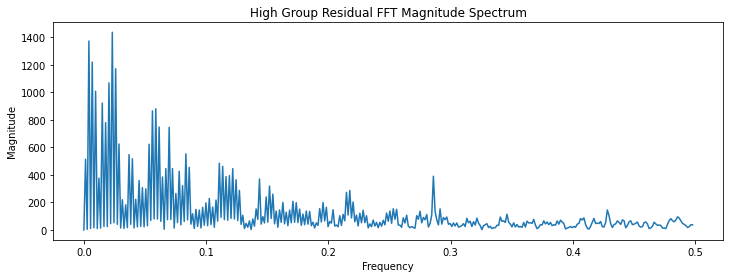

In [246]:
# 7. 퓨리에( Fourier Transform ) "주기적 성분"을 분석하는 도구

'''
퓨리에 분석은 시계열 신호에서 어떤 주파수(주기)가 강한지 확인하여 데이터 특성을 파악하는 도구이다. 

일반적인 흐름은 다음과 같다.
1) 퓨리에 변환(FFT) → 주파수별 성분 분석 → 시각화
2) 필요하면 원하는 주파수(진폭(스펙트럼) 그래프에서 높게 튀어오른 주파수 = 의미 있는 주파수) 성분만 살리고, 
    노이즈(원하지 않는 주파수) 제거 → 주파수 필터링
3) 필터링된 신호를 역변환(iFFT) → 시간 영역의 깨끗한 신호 얻기
4) 이렇게 얻은 신호를 원본 데이터프레임에 새 컬럼으로 넣어 활용
'''

import statsmodels.api as sm
import matplotlib.pyplot as plt

daily_avg_list = []

# 일평균 계산
#일평균으로 변환하면 하루 단위로 변동성을 줄이고, 더 뚜렷한 **계절성(seasonality)**이나 추세(trend)를 파악하기 쉽다.
for df in dfs:
    daily_avg = (
        df.copy()
          .assign(date=lambda x: x['tm'].dt.date)
          .groupby('date')['heat_demand']
          .mean()
    )
    daily_avg_list.append(daily_avg)

high_daily_avg, mid_daily_avg, low_daily_avg = daily_avg_list

# STL 분해 - 기간 설정 (예: 365일 또는 30일)
period = 365  # 여기서 주기 변경 가능 (월단위면 30 또는 31)

high_result = sm.tsa.seasonal_decompose(high_daily_avg, model='additive', period=period)
mid_result = sm.tsa.seasonal_decompose(mid_daily_avg, model='additive', period=period)
low_result = sm.tsa.seasonal_decompose(low_daily_avg, model='additive', period=period)

# residual (잔차)에서 퓨리에 변환
def apply_fft(series):
    series_clean = series.dropna()
    centered = series_clean - series_clean.mean()
    fft_result = np.fft.fft(centered)
    freqs = np.fft.fftfreq(len(centered))
    return freqs, fft_result

high_freqs, high_fft = apply_fft(high_result.resid)
mid_freqs, mid_fft = apply_fft(mid_result.resid)
low_freqs, low_fft = apply_fft(low_result.resid)

# 결과 시각화 (예: 고주파 성분 확인)
plt.figure(figsize=(12, 4))
plt.plot(high_freqs[:len(high_freqs)//2], np.abs(high_fft)[:len(high_fft)//2])
plt.title('High Group Residual FFT Magnitude Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()


In [ ]:
def apply_fft(series):
    series_clean = series.dropna()
    centered = series_clean - series_clean.mean()
    fft_result = np.fft.fft(centered)
    freqs = np.fft.fftfreq(len(centered))
    return freqs, fft_result, series_clean.index  # 시간 단위 인덱스 그대로 반환

#원하는 주파수 대역만 살림
def filter_fft(freqs, fft_vals, low_cutoff=0.0, high_cutoff=0.15):
    filtered_fft = np.zeros_like(fft_vals)
    for i, freq in enumerate(freqs):
        if low_cutoff <= abs(freq) <= high_cutoff:
            filtered_fft[i] = fft_vals[i]
    return filtered_fft

#역 퓨리에 변환(iFFT) 을 통해 다시 시간 영역의 신호로 변환
def apply_ifft(filtered_fft):
    cleaned_signal = np.fft.ifft(filtered_fft)
    return cleaned_signal.real

def process_fft_filtering(df, resid_series):
    # 1) FFT 적용
    freqs, fft_vals, idx = apply_fft(resid_series)
    
    # 2) 주파수 필터링 (필요하면 cutoff 조절)
    filtered_fft = filter_fft(freqs, fft_vals, low_cutoff=0.0, high_cutoff=0.15)
    
    # 3) 역변환
    cleaned_signal = apply_ifft(filtered_fft)
    
    # 4) cleaned_signal을 시리즈로 만들기 (인덱스는 원본 시계열 인덱스 유지)
    cleaned_signal_series = pd.Series(cleaned_signal, index=idx, name='cleaned_residual')
    
    # 5) 인덱스를 datetime 타입으로 변환 (tm 컬럼과 맞추기 위함)
    cleaned_signal_series.index = pd.to_datetime(cleaned_signal_series.index)
    
    # 6) 원본 df에 tm(datetime) 기준으로 merge
    df = df.merge(cleaned_signal_series, how='left', left_on='tm', right_index=True)
    
    return df

# 적용 예시
high_df = process_fft_filtering(high_df, high_result.resid)
mid_df = process_fft_filtering(mid_df, mid_result.resid)
low_df = process_fft_filtering(low_df, low_result.resid)



In [256]:
high_df[high_df['cleaned_residual'].isna()] #15만개가 null값임.. 

,tm,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,...,ta_chi_lag1,heat_demand_lag1,이슬점_lag1,wd_ma,ws_ma,rn_hr1_ma,rn_day_ma,T_wc,T_wc_2,cleaned_residual
1,2021-01-01 01:00:00,A,-10.1,78.3,0.5,0.0,0.0,68.2,0.0,-8.2,...,NaN,NaN,NaN,78.300000,0.500000,0.0,0.0,-6.917847,735.763023,NaN
2,2021-01-01 02:00:00,A,-10.2,71.9,0.6,0.0,0.0,69.9,0.0,-8.6,...,-8.2,281.0,-14.829240,75.100000,0.550000,0.0,0.0,-7.423867,762.305761,NaN
3,2021-01-01 03:00:00,A,-10.0,360.0,0.0,0.0,0.0,69.2,0.0,-8.8,...,-8.6,262.0,-14.627072,170.066667,0.366667,0.0,0.0,6.905000,451.500000,NaN
4,2021-01-01 04:00:00,A,-9.3,155.9,0.5,0.0,0.0,65.0,0.0,-8.9,...,-8.8,266.0,-14.556932,195.933333,0.366667,0.0,0.0,-6.136745,722.106168,NaN
5,2021-01-01 05:00:00,A,-9.0,74.3,1.9,0.0,0.0,63.5,0.0,-9.2,...,-8.9,285.0,-14.646170,196.733333,0.800000,0.0,0.0,-9.027676,940.130048,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473018,2023-12-31 19:00:00,R,5.7,337.9,2.0,2.0,0.0,74.4,0.0,4.4,...,3.4,24.0,2.513233,334.200000,3.066667,0.0,2.0,6.484120,618.130303,NaN
473019,2023-12-31 20:00:00,R,5.5,344.8,1.3,2.0,0.0,78.3,0.0,4.6,...,4.4,26.0,1.505858,337.866667,2.266667,0.0,2.0,6.955040,566.548242,NaN
473020,2023-12-31 21:00:00,R,5.1,338.9,1.4,2.0,0.0,81.5,0.0,5.2,...,4.6,27.0,2.025811,340.533333,1.566667,0.0,2.0,6.424761,584.007252,NaN
473021,2023-12-31 22:00:00,R,4.9,331.9,1.2,2.0,0.0,81.9,0.0,4.9,...,5.2,27.0,2.197390,338.533333,1.300000,0.0,2.0,6.459146,569.150077,NaN


* 일별 평균추세

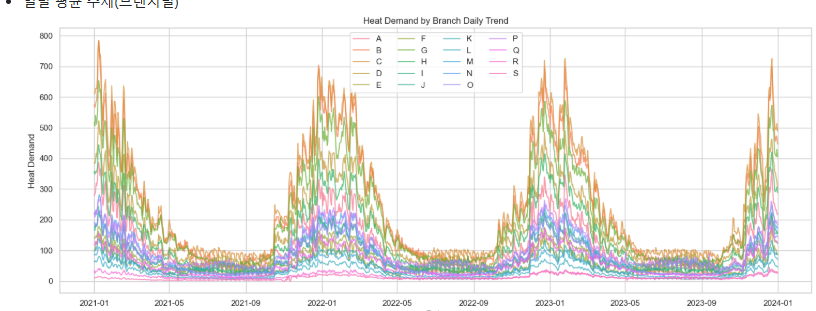

* 시간대별 평균추세

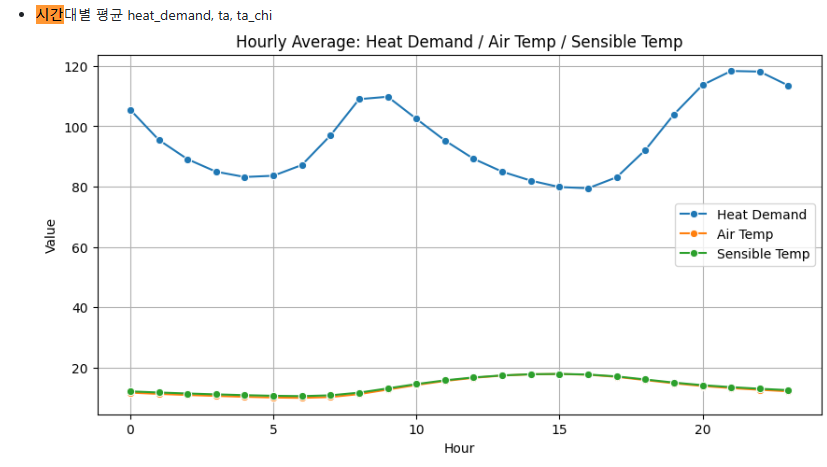

In [ ]:
# 8. trend, 계절성 변수 넣기

'''만약 모델이 (예: LSTM, Transformer) 충분히 복잡해서 패턴을 스스로 잘 학습하면 
굳이 명시적 trend/seasonal 변수를 넣지 않고, 원본 시계열만 써도 됨.high_df
하지만, 일반 회귀/부스팅 모델은 명시적 변수가 성능 향상에 도움됨'''

'''cos,sin보다 더 복잡한 계절성 패턴, 해석과 추세 분리가 필요할 때 사용됨.'''

import statsmodels.api as sm

df_list = [high_df, mid_df, low_df]
daily_avg_list = []

#일평균 반영한 df생성
for df in df_list:
    daily_avg = (
        df.copy()
          .assign(date=lambda x: x['tm'].dt.date)
          .groupby('date')['heat_demand']
          .mean()
    )
    daily_avg_list.append(daily_avg)

# 결과는 daily_avg_list에 [high_daily_avg, mid_daily_avg, low_daily_avg] 형태로 저장됨
high_daily_avg, mid_daily_avg, low_daily_avg = daily_avg_list

# STL 분해
high_result = sm.tsa.seasonal_decompose(high_daily_avg, model='additive', period=365)
mid_result =  sm.tsa.seasonal_decompose(mid_daily_avg, model='additive', period=365)
low_result =  sm.tsa.seasonal_decompose(low_daily_avg, model='additive', period=365)

high_df['trend'] = high_result.trend
high_df['seasonal'] = high_result.seasonal
high_df['residual'] = high_result.resid

mid_df['trend'] = mid_result.trend
mid_df['seasonal'] = mid_result.seasonal
mid_df['residual'] = mid_result.resid

low_df['trend'] = low_result.trend
low_df['seasonal'] = low_result.seasonal
low_df['residual'] = low_result.resid

In [ ]:
# 9. 시계열분해 결과 반영 - 주기성, 계절성 반영
for df in dfs:
    df['hour'] = df['tm'].dt.hour
    df['hour_of_week'] = df['tm'].dt.dayofweek * 24 + df['hour']
    df['day_of_month'] = df['tm'].dt.day

    # 하루 단위 
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    # 일주일 단위
    df['weekhour_sin'] = np.sin(2 * np.pi * df['hour_of_week'] / 168)
    df['weekhour_cos'] = np.cos(2 * np.pi * df['hour_of_week'] / 168)
    # 월 단위 
    df['month_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 30)
    df['month_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 30)

<ipython-input-144-a826cdc1d253>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['tm'].dt.hour
<ipython-input-144-a826cdc1d253>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour_of_week'] = df['tm'].dt.dayofweek * 24 + df['hour']
<ipython-input-144-a826cdc1d253>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [ ]:
# 10. 스플라인변환 (sin, cos 과 동시 사용x)
# ! pip install patsy

# import numpy as np
# import pandas as pd
# from patsy import dmatrix

# df_list = [high_df, mid_df, low_df]
# date_col = 'tm'

# def add_periodic_spline(df, date_col, period=24, n_splines=6, spline_degree=3):
#     if period == 24:
#         x = df[date_col].dt.hour
#     elif period == 168:
#         x = df[date_col].dt.dayofweek * 24 + df[date_col].dt.hour
#     elif period == 30:
#         x = df[date_col].dt.day
#     else:
#         raise ValueError("period 값이 정의되지 않았습니다.")
        
#     x = x % period
    
#     spline_basis = dmatrix(f"bs(x, df={n_splines}, degree={spline_degree}, include_


PatsyError: Error evaluating factor: TypeError: memorize_chunk() got an unexpected keyword argument 'periodic'
    bs(x, df=6, degree=3, include_intercept=True, periodic=True) - 1
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

===== DataFrame 1 - 일평균 시계열 =====


c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\

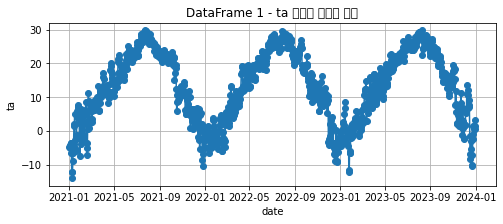

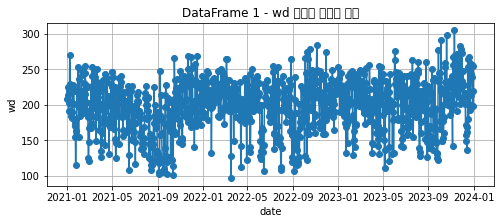

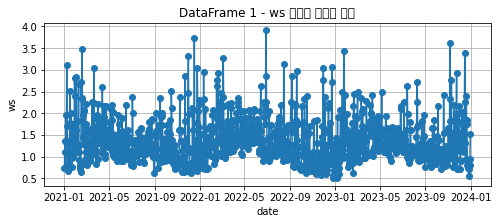

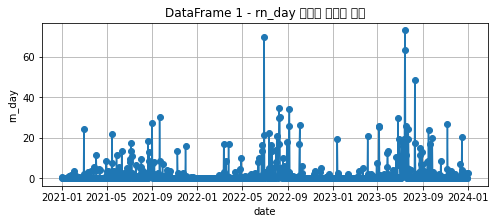

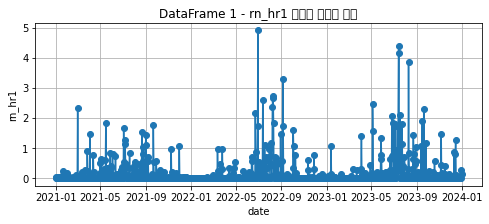

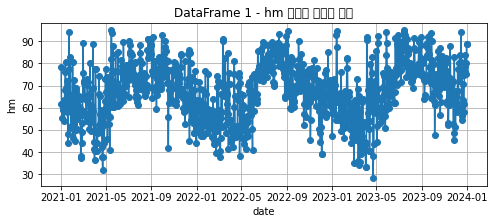

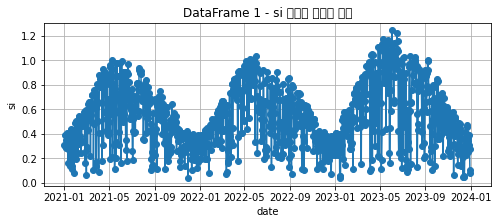

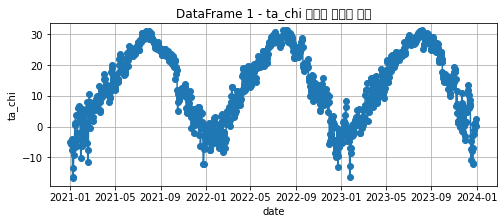

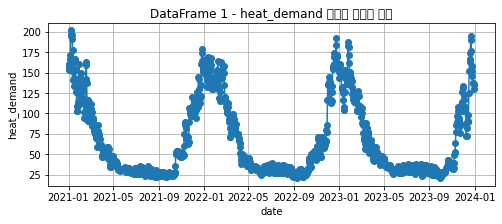

c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 49836 (\N{HANGUL SYLLABLE SEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


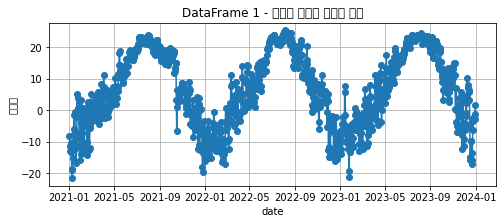

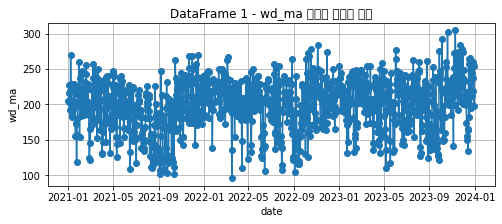

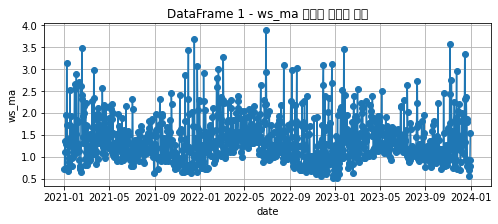

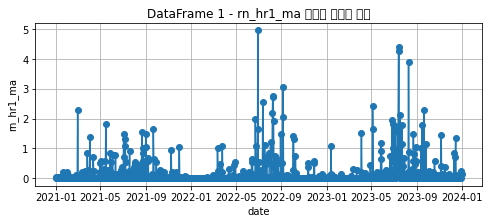

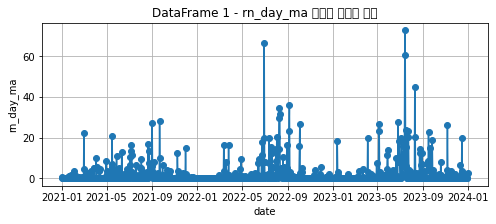

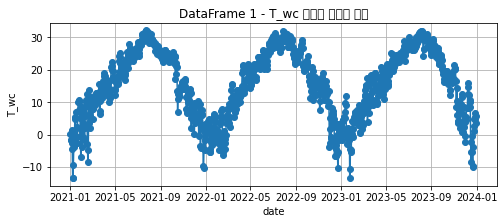

===== DataFrame 2 - 일평균 시계열 =====


c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\

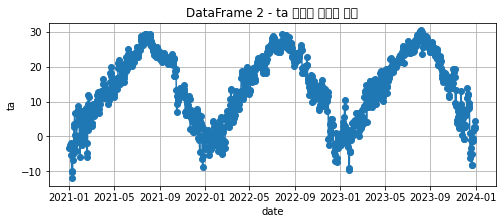

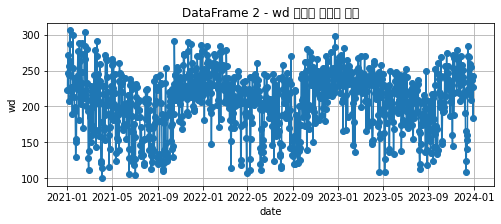

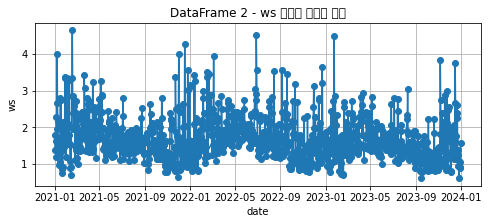

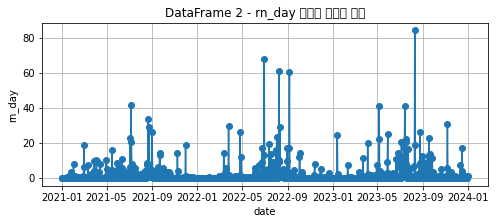

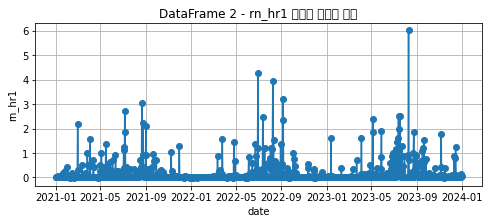

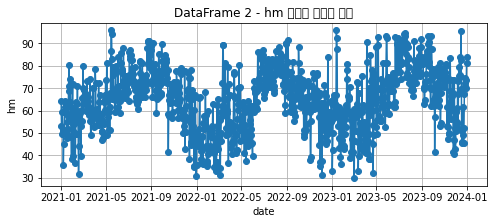

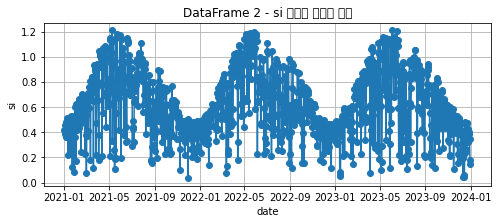

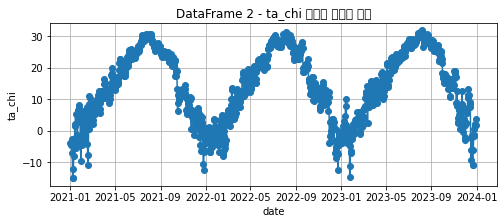

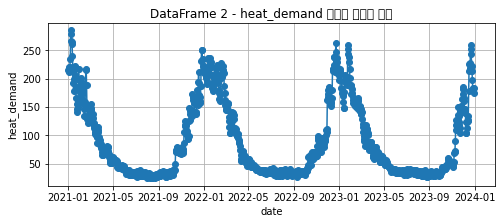

c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 49836 (\N{HANGUL SYLLABLE SEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


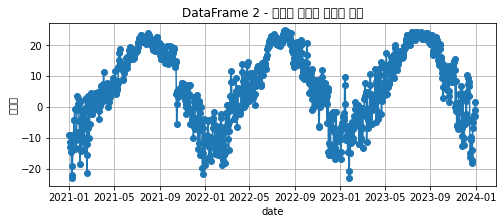

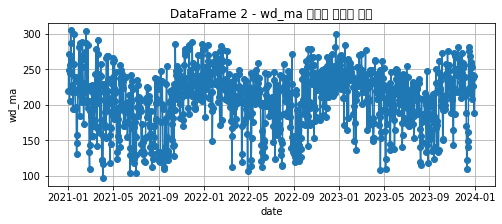

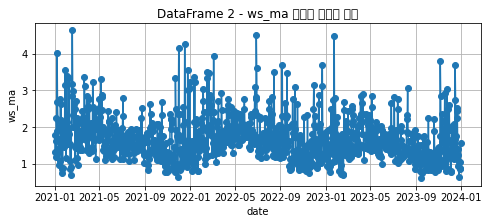

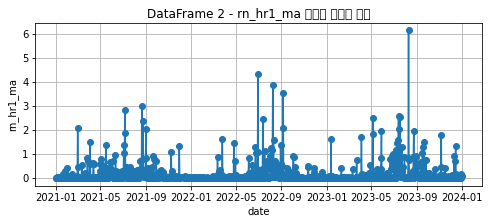

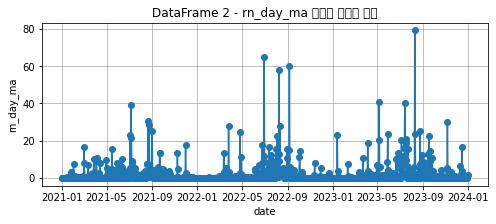

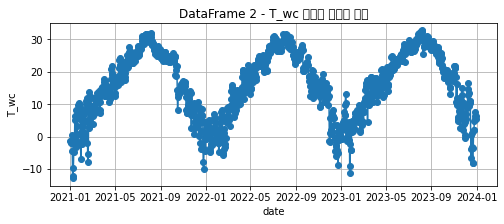

===== DataFrame 3 - 일평균 시계열 =====


c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\

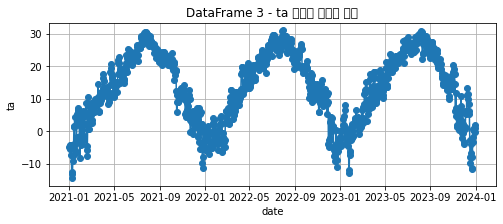

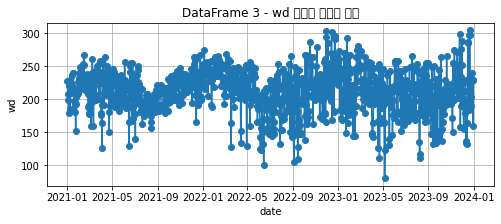

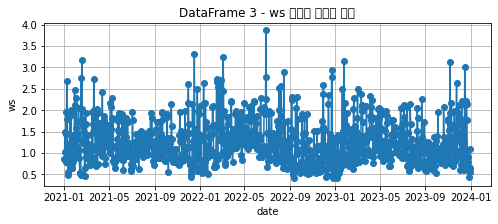

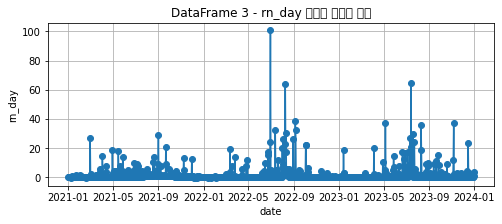

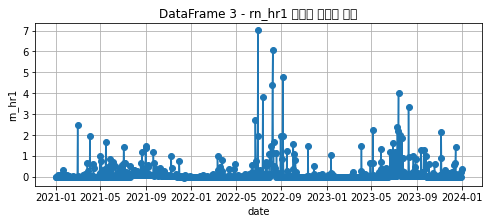

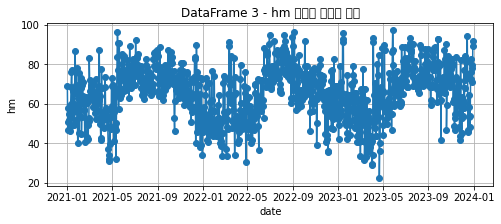

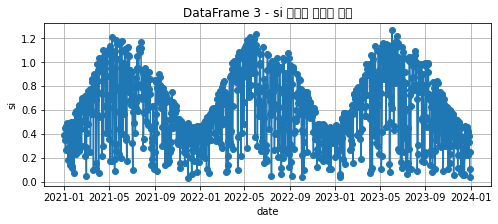

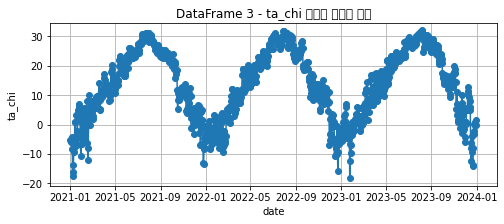

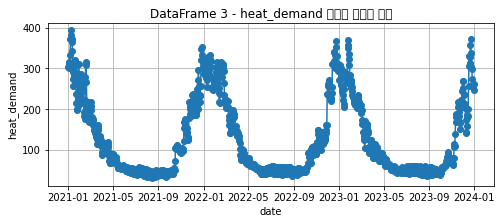

c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 49836 (\N{HANGUL SYLLABLE SEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


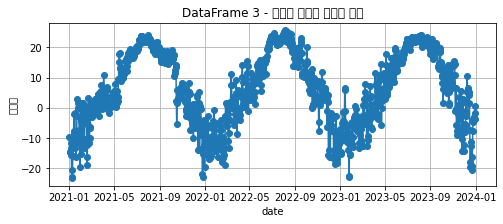

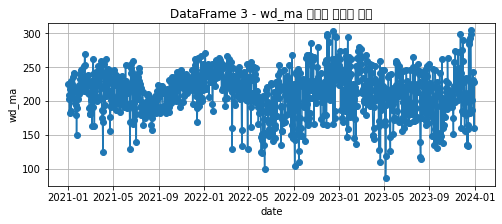

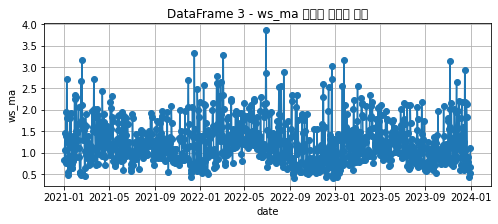

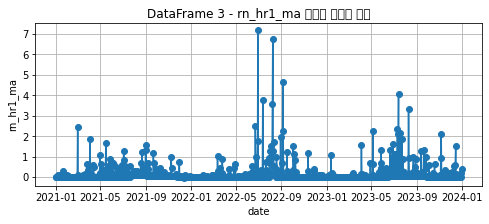

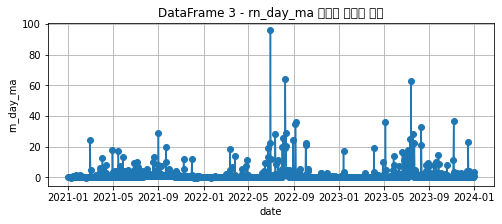

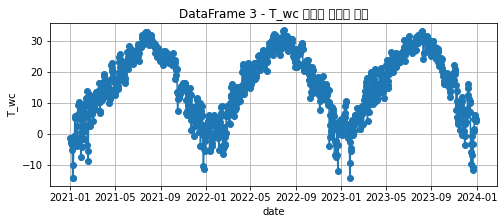

In [ ]:
# 11. ma) 이동평균해야하는 변수 시각화 code

# 어떤 변수들로 이동평균 파생변수 만들건지, 변동성이 큰 변수 파악하기 
# wd, ws, rn_hr1, rn_day가 들쭉날쭉한 그래프를 그리는 것 같음. 

'''1. 들쭉날쭉, 노이즈 많고 불규칙한 변수 → 이동평균 추천
시계열 그래프가 급격히 위아래 튀는 패턴 → 이동평균으로 부드럽게 평활화 가능

2. 이미 주기성이 있는 변수는 이동평균 추천 x
'''

import matplotlib.pyplot as plt
for i, df in enumerate(dfs, start=1):
    print(f"===== DataFrame {i} - 일평균 시계열 =====")
    
    df['tm'] = pd.to_datetime(df['tm'])
    df['date'] = df['tm'].dt.date
    
    # 수치형 컬럼만 선택
    numeric_cols = df.select_dtypes(include='number').columns
    
    # 날짜별 수치형 컬럼 평균 계산
    daily_mean = df.groupby('date')[numeric_cols].mean().reset_index()
    daily_mean['date'] = pd.to_datetime(daily_mean['date'])
    
    for col in numeric_cols:
        plt.figure(figsize=(8,3))
        plt.plot(daily_mean['date'], daily_mean[col], marker='o')
        plt.title(f"DataFrame {i} - {col} 일평균 시계열 추이")
        plt.xlabel("date")
        plt.ylabel(col)
        plt.grid(True)
        plt.show()



### 로그변환

In [ ]:
# 타겟변수 로그변환
high_df['log_heat_demand'] = np.log1p(high_df['heat_demand'])
mid_df['log_heat_demand'] = np.log1p(mid_df['heat_demand'])
low_df['log_heat_demand'] = np.log1p(low_df['heat_demand'])


<ipython-input-90-4a133abe26ee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_df['log_heat_demand'] = np.log1p(high_df['heat_demand'])
<ipython-input-90-4a133abe26ee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mid_df['log_heat_demand'] = np.log1p(mid_df['heat_demand'])
<ipython-input-90-4a133abe26ee>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:


===== high 클러스터 전체 변수 분포 =====


c:\Users\USER\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\USER\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\USER\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\USER\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


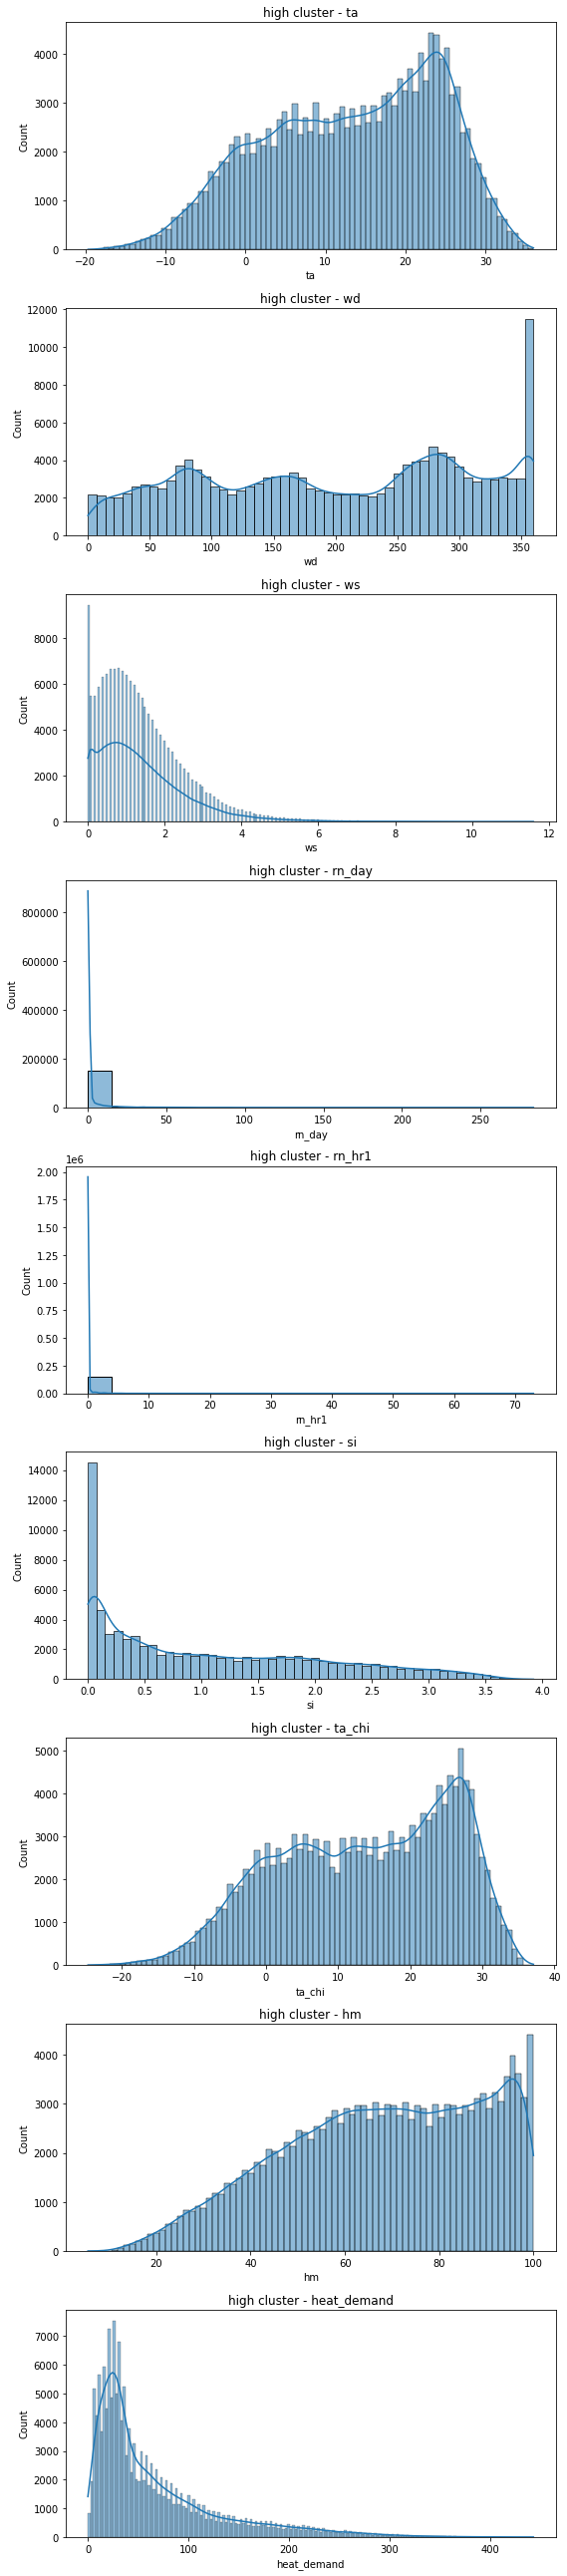


===== mid 클러스터 전체 변수 분포 =====


c:\Users\USER\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\USER\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\USER\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\USER\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


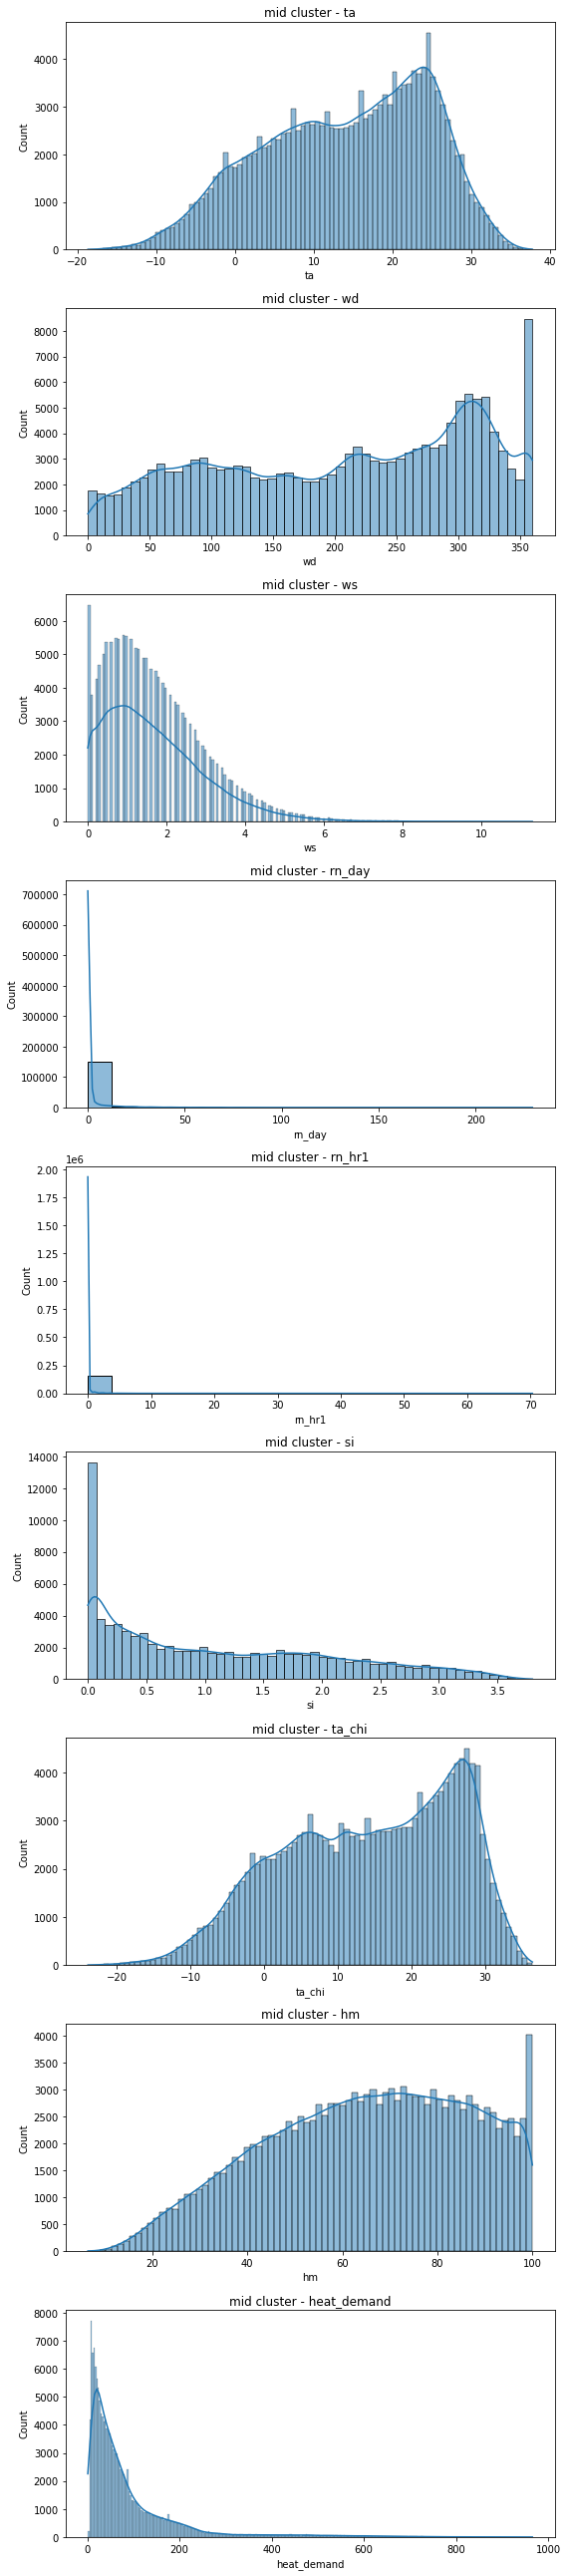


===== low 클러스터 전체 변수 분포 =====


c:\Users\USER\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\USER\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\USER\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\USER\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


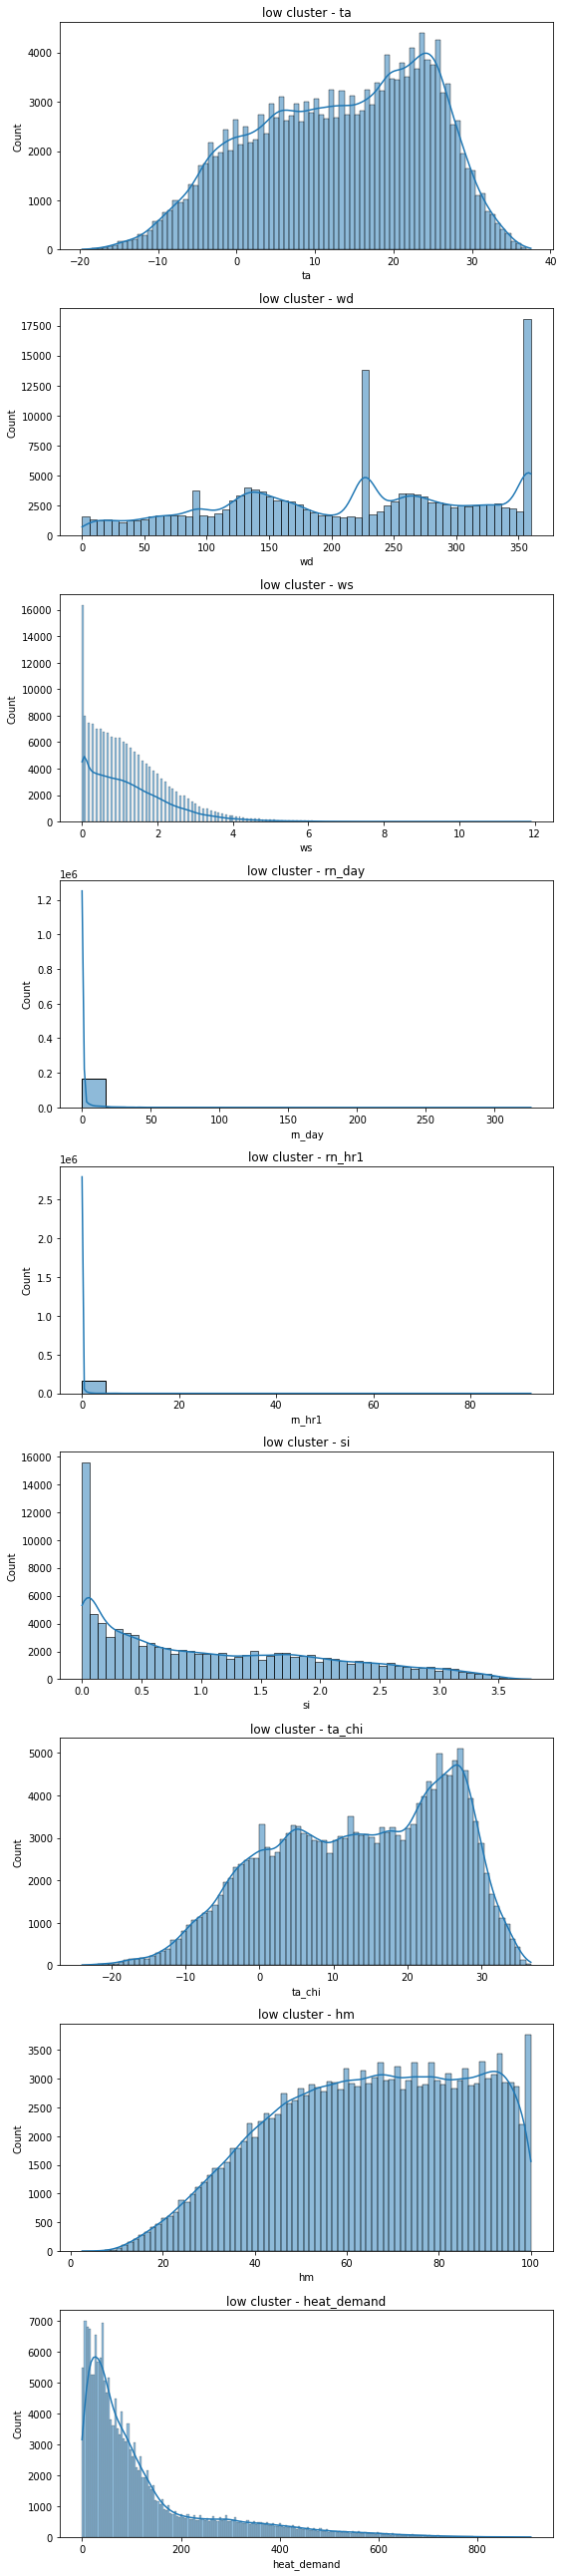

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import numpy as np

def plot_cluster_distributions(df, cluster_name):
    vars_to_check = ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1','si','ta_chi','hm', 'heat_demand']

    print(f"\n===== {cluster_name} 클러스터 전체 변수 분포 =====")
    plt.figure(figsize=(15, 4 * len(vars_to_check)))

    for i, var in enumerate(vars_to_check, 1):
        data_original = df[var].dropna()
        data_log = np.log1p(data_original)

        # 원본 분포
        plt.subplot(len(vars_to_check), 2, 2*i-1)
        sns.histplot(data_original, kde=True)
        plt.title(f'{cluster_name} cluster - {var}')

        # # 로그 변환 분포
        # plt.subplot(len(vars_to_check), 2, 2*i)
        # sns.histplot(data_log, kde=True)
        # plt.title(f'{cluster_name} 클러스터 - {var} 로그 변환 분포')

        # # skewness 출력
        # print(f"{var} 원본 Skewness: {skew(data_original):.3f}")
        # print(f"{var} 로그 변환 Skewness: {skew(data_log):.3f}\n")

    plt.tight_layout()
    plt.show()

# 실행
plot_cluster_distributions(high_df, 'high')
plot_cluster_distributions(mid_df, 'mid')
plot_cluster_distributions(low_df, 'low')


In [94]:
import numpy as np
from scipy.stats import skew

# 확인할 변수 리스트
vars_to_check = ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1','si','ta_chi','hm', 'heat_demand']

# 클러스터별 데이터프레임 딕셔너리
cluster_dfs = {
    'high': high_df,
    'mid': mid_df,
    'low': low_df
}

for cluster_name, df in cluster_dfs.items():
    print(f"===== Cluster: {cluster_name} =====")
    for var in vars_to_check:
        data = df[var].dropna()
        data_log = np.log1p(data)  # 로그 변환 (log1p는 log(1+x)로 0값도 처리 가능)

        skew_orig = skew(data)
        skew_log = skew(data_log)

        print(f"{var}: 원본 왜도 = {skew_orig:.3f}, 로그 변환 왜도 = {skew_log:.3f}")
    print("\n")


===== Cluster: high =====
ta: 원본 왜도 = -0.314, 로그 변환 왜도 = nan
wd: 원본 왜도 = -0.127, 로그 변환 왜도 = -1.789
ws: 원본 왜도 = 1.351, 로그 변환 왜도 = 0.172
rn_day: 원본 왜도 = 11.502, 로그 변환 왜도 = 3.073


c:\Users\USER\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\USER\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


rn_hr1: 원본 왜도 = 17.082, 로그 변환 왜도 = 6.448
si: 원본 왜도 = 0.697, 로그 변환 왜도 = 0.193
ta_chi: 원본 왜도 = -0.309, 로그 변환 왜도 = nan
hm: 원본 왜도 = -0.347, 로그 변환 왜도 = -1.123
heat_demand: 원본 왜도 = 1.697, 로그 변환 왜도 = -0.189


===== Cluster: mid =====
ta: 원본 왜도 = -0.331, 로그 변환 왜도 = nan
wd: 원본 왜도 = -0.293, 로그 변환 왜도 = -1.959
ws: 원본 왜도 = 1.130, 로그 변환 왜도 = 0.000
rn_day: 원본 왜도 = 10.214, 로그 변환 왜도 = 3.161
rn_hr1: 원본 왜도 = 17.497, 로그 변환 왜도 = 6.497
si: 원본 왜도 = 0.622, 로그 변환 왜도 = 0.111
ta_chi: 원본 왜도 = -0.341, 로그 변환 왜도 = nan
hm: 원본 왜도 = -0.268, 로그 변환 왜도 = -1.051
heat_demand: 원본 왜도 = 2.992, 로그 변환 왜도 = 0.142


===== Cluster: low =====
ta: 원본 왜도 = -0.283, 로그 변환 왜도 = nan
wd: 원본 왜도 = -0.199, 로그 변환 왜도 = -2.287
ws: 원본 왜도 = 1.393, 로그 변환 왜도 = 0.217
rn_day: 원본 왜도 = 10.505, 로그 변환 왜도 = 3.143
rn_hr1: 원본 왜도 = 22.706, 로그 변환 왜도 = 6.487
si: 원본 왜도 = 0.642, 로그 변환 왜도 = 0.134
ta_chi: 원본 왜도 = -0.315, 로그 변환 왜도 = nan
hm: 원본 왜도 = -0.254, 로그 변환 왜도 = -1.055
heat_demand: 원본 왜도 = 1.843, 로그 변환 왜도 = -0.380


